In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


In [6]:
data_dir = './kaggle_kakr_housing/data'

data = pd.read_csv(join(data_dir, 'train.csv'))
sub = pd.read_csv(join(data_dir, 'test.csv'))
print(f'train data dim : {data.shape}')
print(f'sub data dim : {sub.shape}')

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [7]:
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='str')


In [8]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [9]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<Axes: >

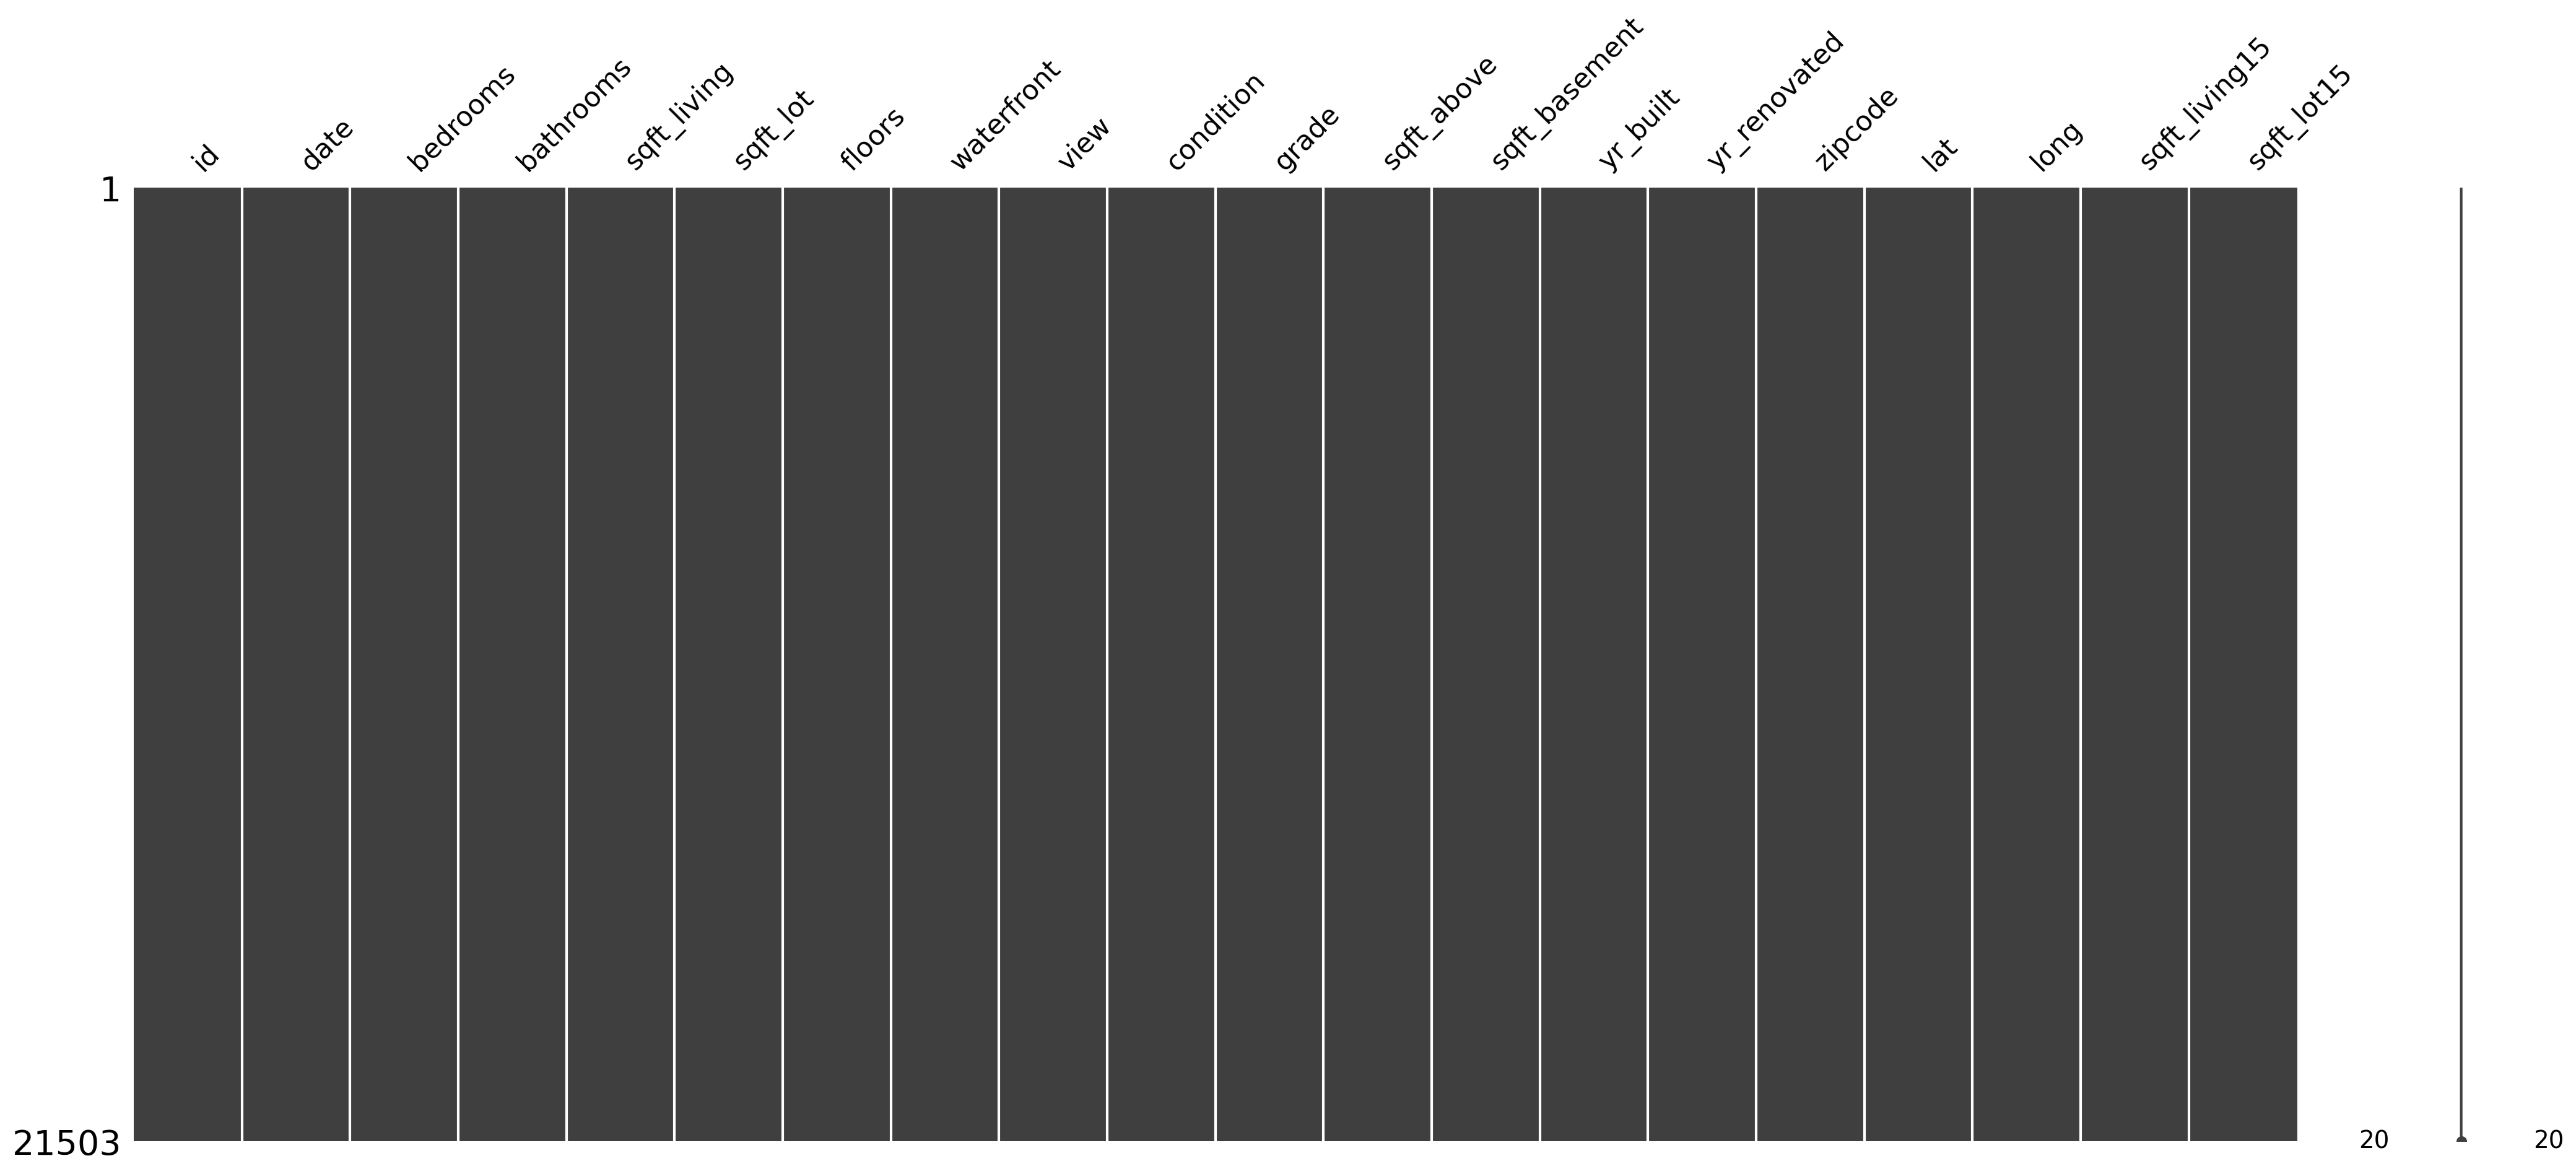

In [10]:
msno.matrix(data)

In [11]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [12]:
# 2. 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [13]:
# 3. 결측치인 데이터의 개수를 셉니다.
print(f'id: {len(null_data.values)}')

id: 0


In [14]:
# 3. 결측치인 데이터의 개수를 셉니다.
print(f'id: {len(null_data.values)}')

id: 0


In [15]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [16]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='str')


In [17]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


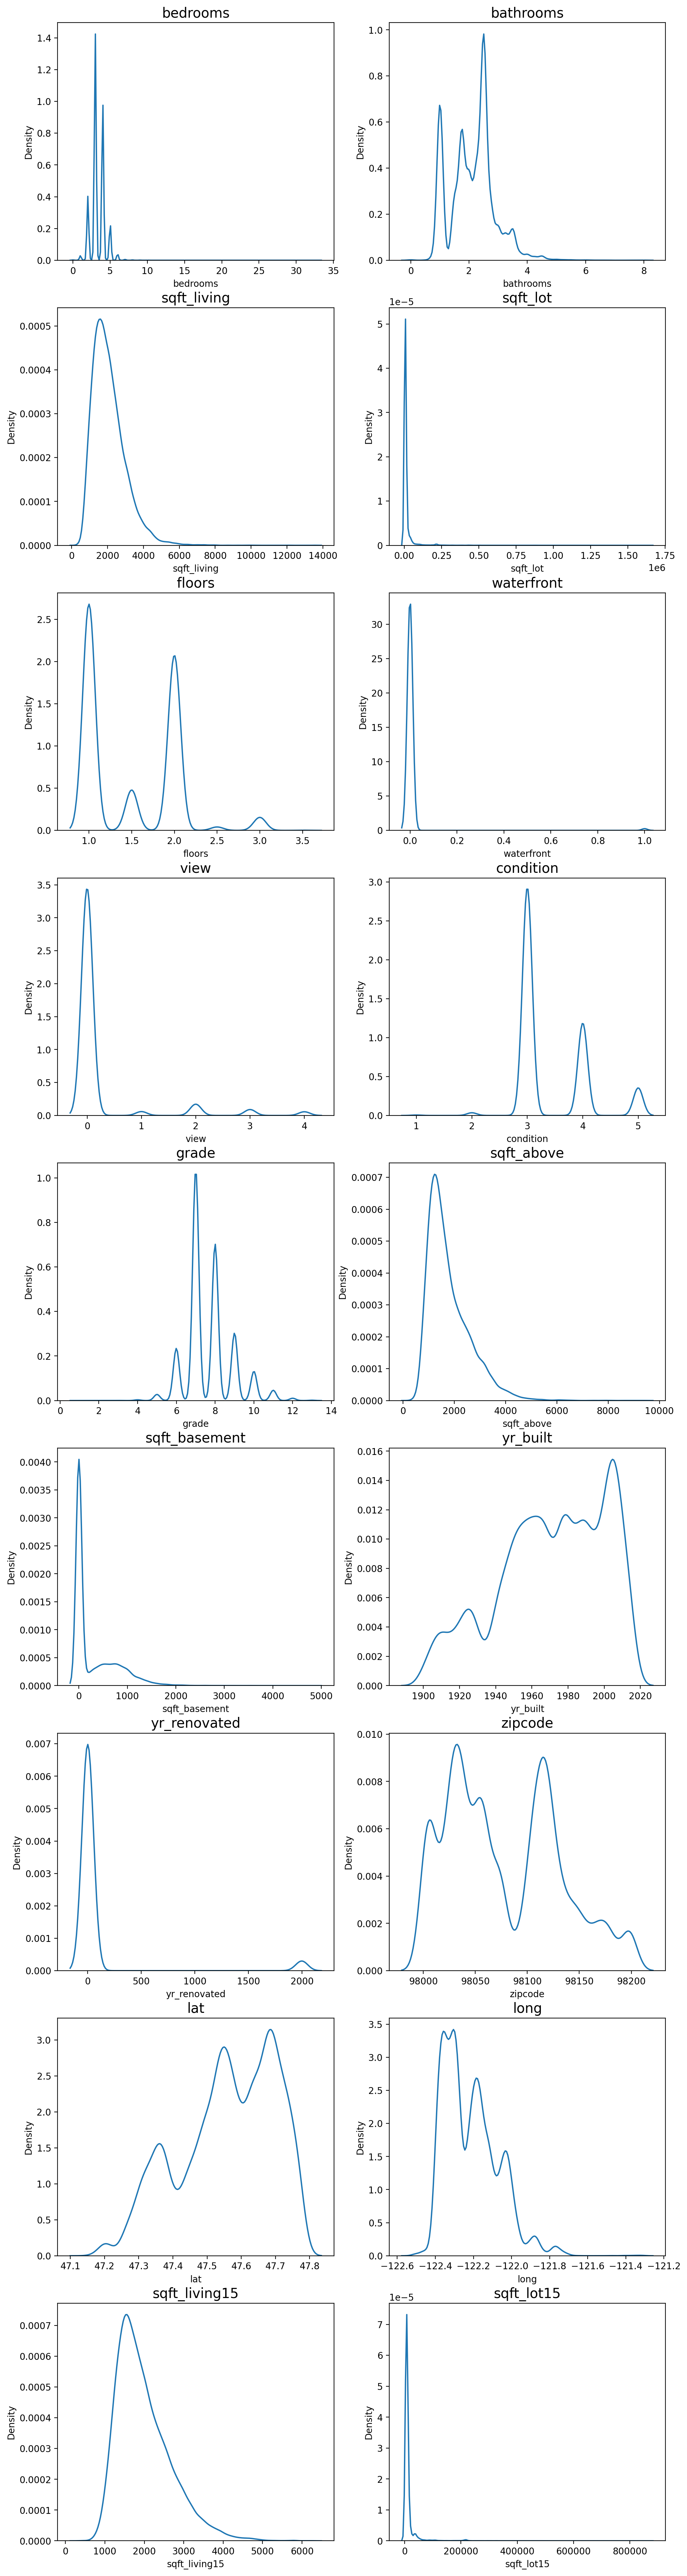

In [18]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요.

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [19]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('얍💢')

얍💢


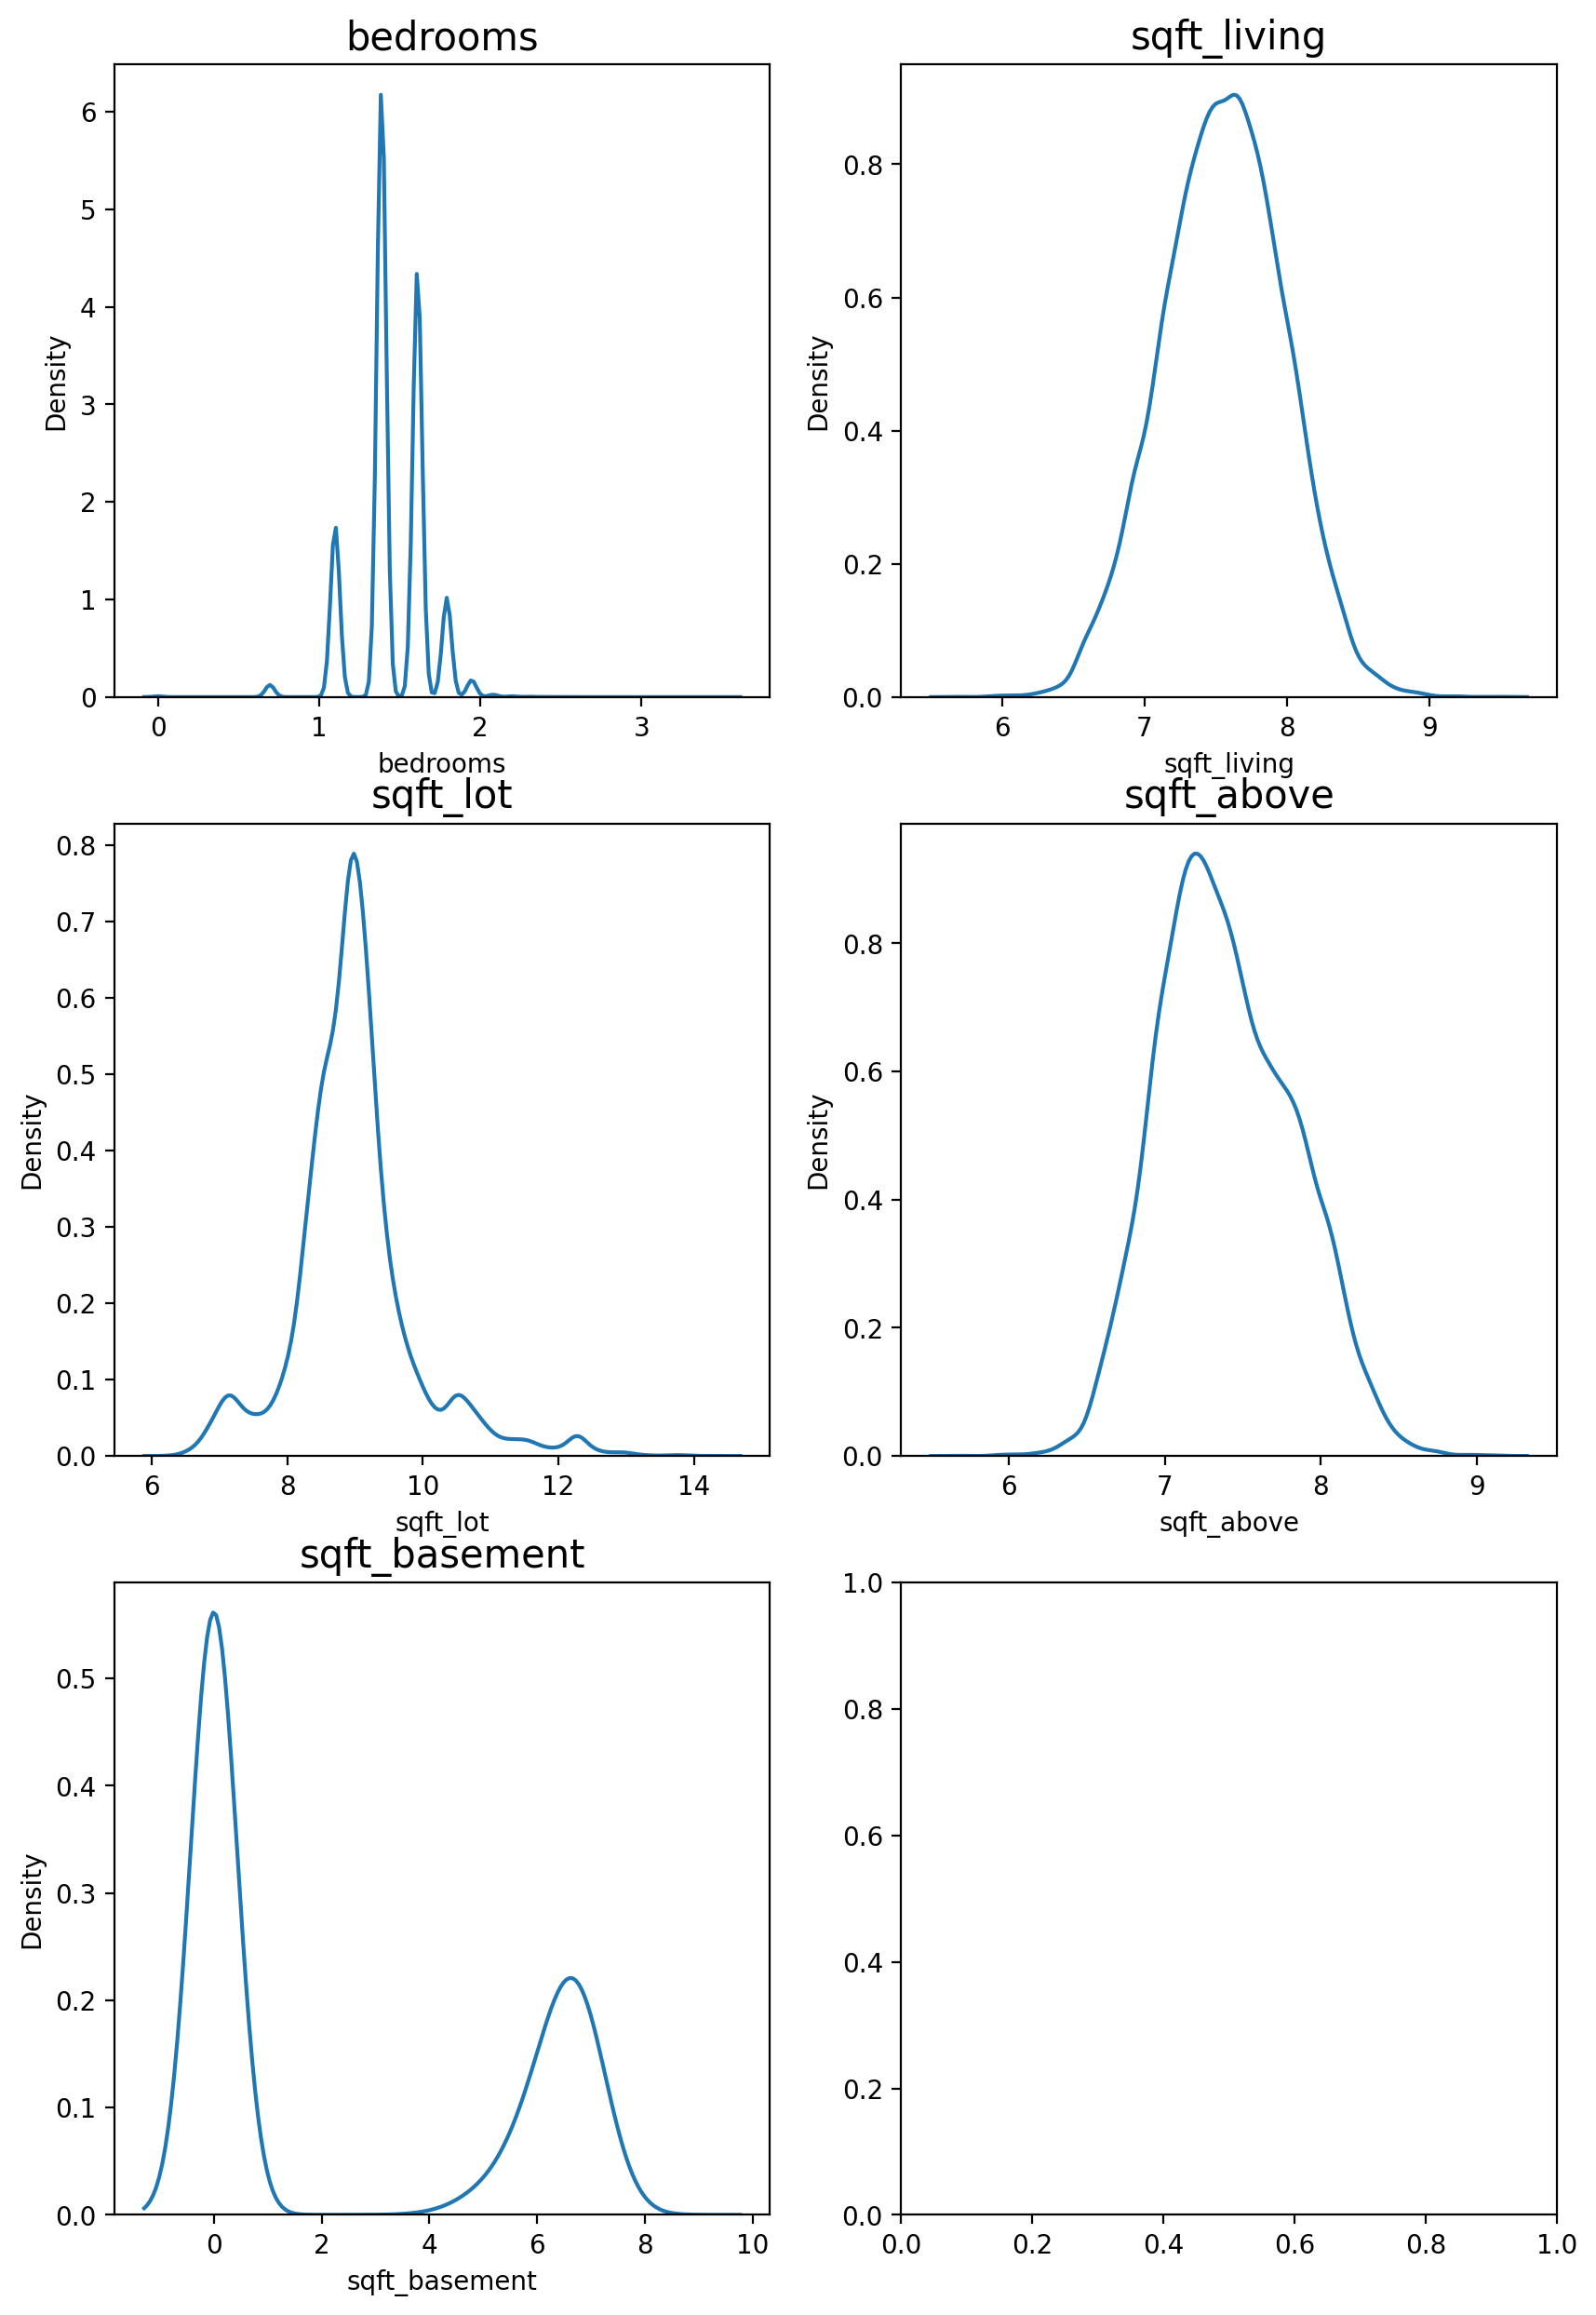

In [20]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

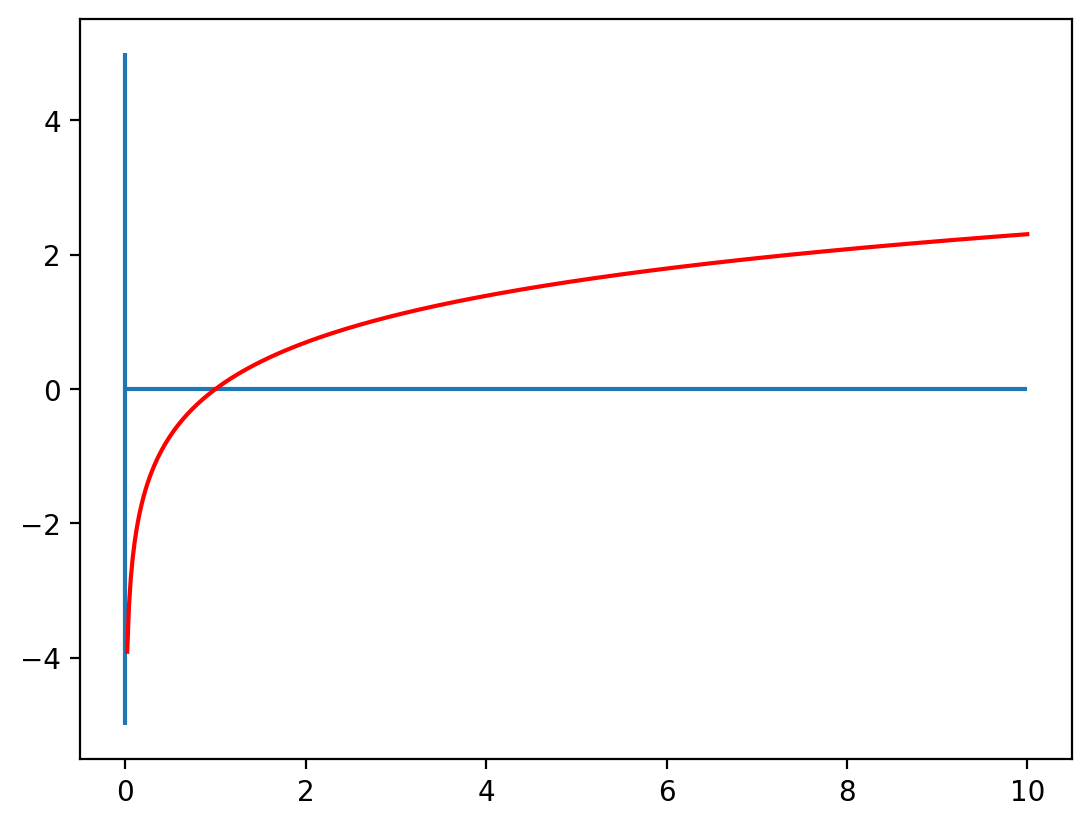

In [21]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

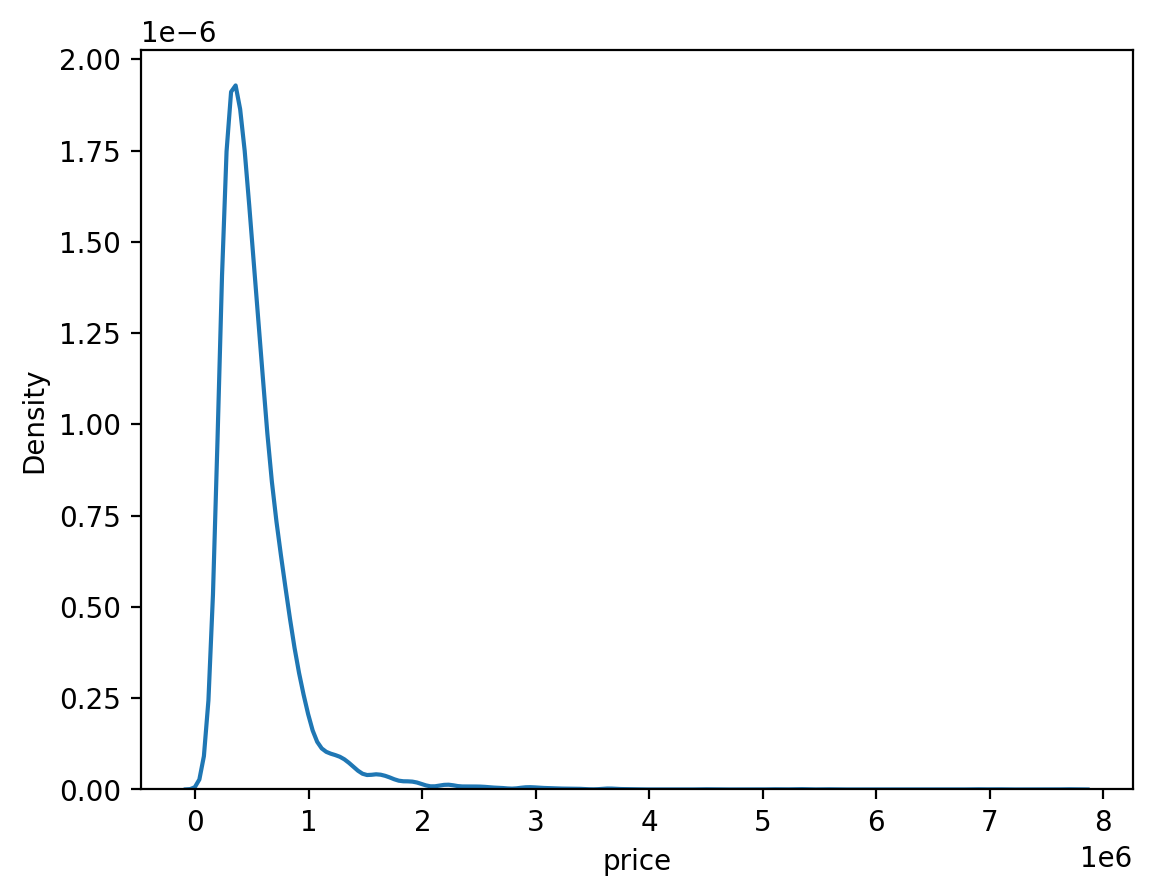

In [23]:
sns.kdeplot(y)
plt.show()

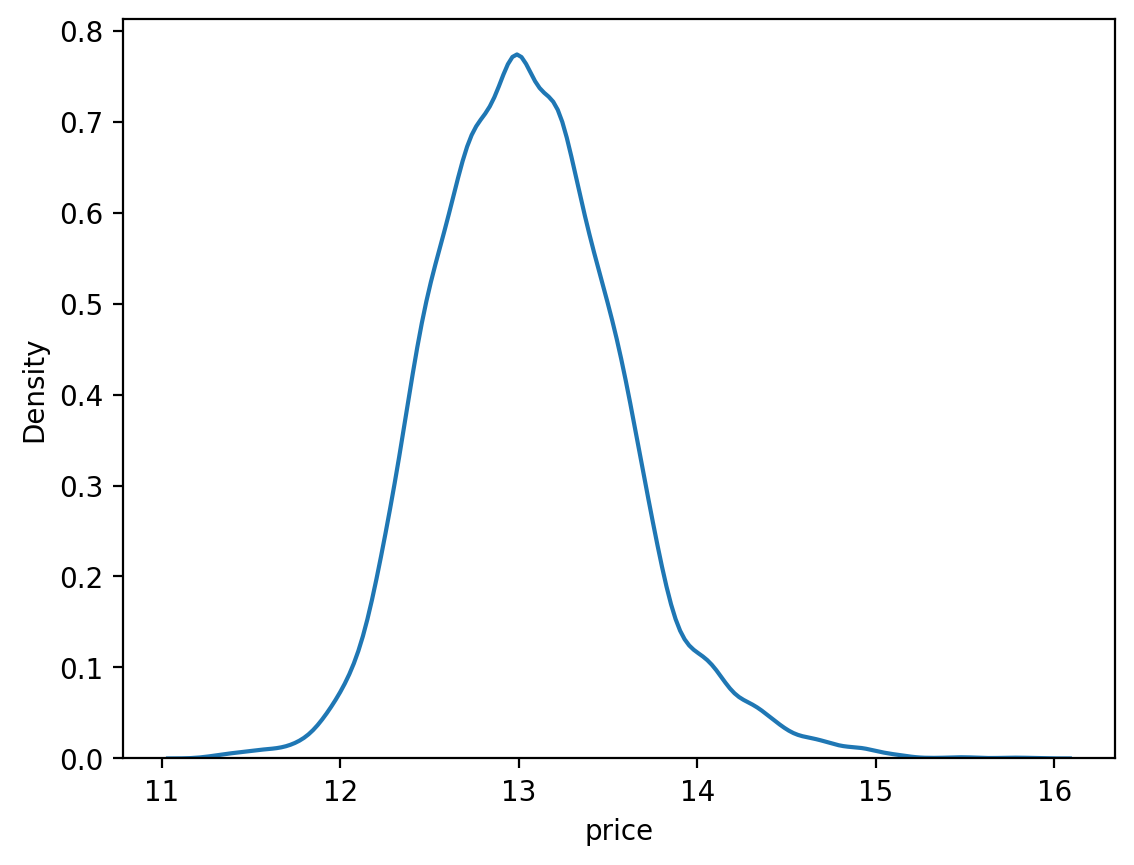

In [24]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [25]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


In [26]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


In [ ]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('얍💢')

얍💢


In [28]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp312-cp312-macosx_12_0_arm64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp312-cp312-macosx_12_0_arm64.whl (11.0 MB)

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [33]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 540497.991270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 542956.681826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
Y

In [30]:
def AveragingBlending(models, x, y, sub_x):
    for m in models :
        m['model'].fit(x.values, y)

    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('얍💢')

얍💢


In [31]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 540682.653143
6468


array([ 548944.53804912,  443655.17105951, 1345797.07909443, ...,
        457185.23303678,  339532.04977609,  422564.70651683],
      shape=(6468,))

In [34]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [35]:
result = pd.DataFrame({
    'id' : sub_id,
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.489445e+05
1,15036,4.436552e+05
2,15037,1.345797e+06
3,15038,3.206119e+05
4,15039,3.180479e+05


In [36]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

./kaggle_kakr_housing/data/submission.csv
